# Imports

In [1]:
import pandas as pd
import os
from utils.plotter import PlotResults
from utils.utils import align_predictions
from run import *

In [2]:
argv = """
--data_path Total.csv 
--model DLinear --test
""".split()
parser = get_parser()
args = parser.parse_args(argv)
print(args)

setting = stringify_setting(args)

Namespace(test=True, model='DLinear', seed=7, root_path='./dataset/processed/', data_path='Total.csv', result_path='results', freq='d', no_scale=False, seq_len=14, label_len=7, pred_len=14, top_k=5, num_kernels=6, d_model=64, n_heads=4, e_layers=2, d_layers=1, d_ff=256, moving_avg=7, factor=3, distil=True, dropout=0.1, embed='timeF', activation='gelu', output_attention=False, num_workers=0, train_epochs=10, batch_size=32, patience=3, learning_rate=0.001, des='', loss='MSE', lradj='type1', use_amp=False, no_gpu=False, gpu=0, use_multi_gpu=False, devices='0,1,2,3', p_hidden_dims=[64, 64], p_hidden_layers=2, disable_progress=False)


# Ground Truth

In [3]:
from data.data_factory import AgeData
from exp.config import Split

age_data = AgeData.build(args)
total_data = age_data.read_df()
train, val, test, _ = age_data.split_data(
    total_data, Split.primary()
)

adding time index columns TimeFromStart
added time encoded known reals ['month', 'day', 'weekday'].

Train samples 2001454, validation samples 87976,             test samples 87976, last samples 1253658
637 days of training, 14 days of validation data,             14 days of test data and 385 of data after test start.

Fitting scalers on train data


In [4]:
flag = 'test'
dataset_root = os.path.join(DataConfig.root_folder, args.data_path.split('.')[0])
path = os.path.join(dataset_root, f'{flag}.pt')
ts_dataset = None
if os.path.exists(path):
    print(f'Loading dataset from {path}')
    ts_dataset = torch.load(path)

dataset, dataloader = age_data.create_tslib_timeseries(
    data=test, train=False, 
    ts_dataset=ts_dataset # using a cached dataset help speeding up
)

Loading dataset from ./dataset/processed\Total\test.pt


In [5]:
time_index = age_data.time_index
predictions_index = pd.DataFrame(
    dataset.ranges, 
    columns=age_data.group_ids + [time_index]
)
predictions_index[time_index] += args.pred_len + test[time_index].min()

# Combine predictions

In [6]:
models = ['Autoformer', 'FEDformer', 'PatchTST', 'TimesNet', 'Crossformer']
predictions = []

for model_name in models:
    data_file = args.data_path.split('.')[0]
    filename = os.path.join(
        args.result_path, model_name + '_' + data_file, 'test_pred.npy'
    )
    test_pred = np.load(filename)
    pred_list = [
        test_pred[:, :, target] for target in range(test_pred.shape[-1])
    ]
    
    # preds and trues were already upscaled during saving
    merged = align_predictions(
        test, predictions_index, 
        pred_list, age_data, upscale=False
    )
    
    merged = merged.groupby('Date')[
        'Cases', 'Predicted_Cases'
    ].aggregate('sum').reset_index()
    merged['Model'] = model_name
    
    predictions.append(merged)
    
df = pd.concat(predictions, axis=0).reset_index(drop=True)

In [7]:
summed = test.groupby('Date')['Cases'].aggregate('sum').reset_index()

In [8]:
summed['Cases'].describe()

count        28.000000
mean     124876.089286
std       61145.644491
min       23571.000000
25%       68735.500000
50%      131561.750000
75%      163523.625000
max      251302.500000
Name: Cases, dtype: float64

In [9]:
df[df['Model']=='TimesNet'][['Cases', 'Predicted_Cases']].describe()

,Cases,Predicted_Cases
count,14.000000,14.000000
mean,141509.857143,107208.328125
std,65734.334463,4139.444824
min,44003.000000,100287.515625
25%,79881.875000,104298.408203
50%,150782.750000,108150.210938
75%,185904.000000,109418.335938
max,251302.500000,113359.734375


# Plot

In [10]:
from exp.plot_config import *

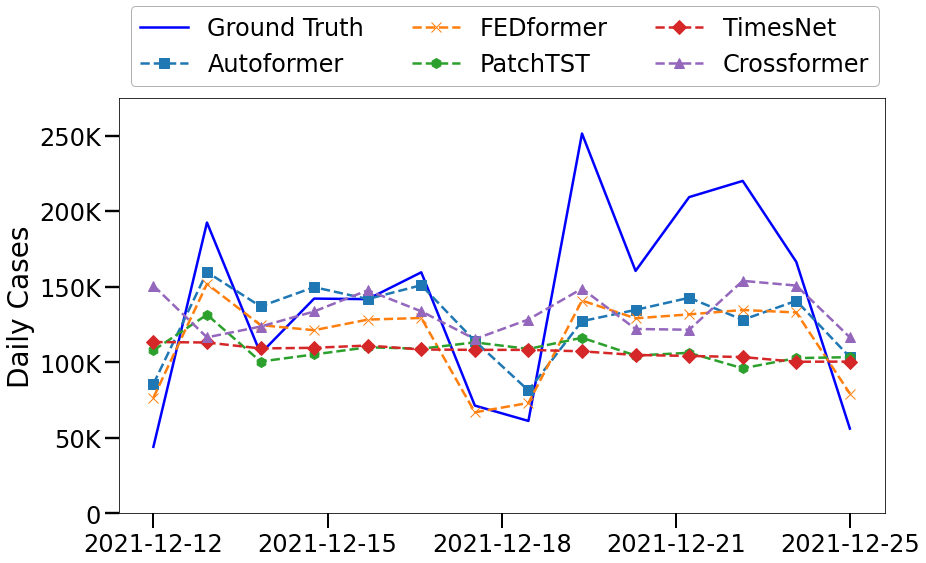

In [11]:
markers = ['s', 'x', 'h', 'D', '^', '>', 'p', '<', '*', 'P', '.', '+',  'v']
fig, ax = plt.subplots(figsize=(13, 8))
x_column = 'Date'
target = "Cases"

prop_cycle = iter(plt.rcParams["axes.prop_cycle"])
X = df[df['Model']==models[0]][x_column]
Y = df[df['Model']==models[0]][target]

# plot ground truth
ax.plot(
    X, Y, 
    color='blue', label='Ground Truth'
)

for index, name in enumerate(models):
    data = df[df['Model']==name]

    ax.plot(
        data[x_column], data[f'Predicted_{target}'], 
        color=next(prop_cycle)["color"], label=name, linestyle='--',
        marker=markers[index], markersize=10
    )

_, y_max = ax.get_ylim()
ax.set_ylim(0, y_max*1.05)

x_first_tick = df[x_column].min()
x_last_tick = df[x_column].max()
x_major_ticks = 5
ax.set_xticks(
    [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) 
     for i in range(x_major_ticks)]
)

label_text = [] 
for loc in ax.get_yticks():
    if loc == 0:
        label_text.append('0')
    else:
        label_text.append(f'{loc/1e3:0.5g}K') 

ax.set_yticklabels(label_text)

ax.legend(loc='upper left', framealpha=0.3, edgecolor="black", ncol=3, bbox_to_anchor = (0, 1.25))

ax.set_ylabel('Daily Cases')

# tight layout is changing y axis values
fig.tight_layout() # might change y axis values
plt.savefig(os.path.join(args.result_path, 'Test_comparison.jpg'), bbox_inches="tight")
plt.show()